In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST

from tqdm.notebook import tqdm
import seaborn as sns

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import os
if not os.path.exists('plots'):
    os.makedirs('plots')
if not os.path.exists('models'):
    os.makedirs('models')

Using device: cuda:0


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = FashionMNIST(
    root='./data', 
    train=True,
    download=True, 
    transform=transform
)

test_dataset = FashionMNIST(
    root='./data', 
    train=False,
    download=True, 
    transform=transform
)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size = 128 

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True, 
    num_workers=2
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size,
    shuffle=False, 
    num_workers=2
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size,
    shuffle=False, 
    num_workers=2
)


class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of classes: {len(class_names)}")
print(f"Image dimensions: {train_dataset[0][0].shape}")

Training dataset size: 48000
Validation dataset size: 12000
Test dataset size: 10000
Number of classes: 10
Image dimensions: torch.Size([1, 28, 28])


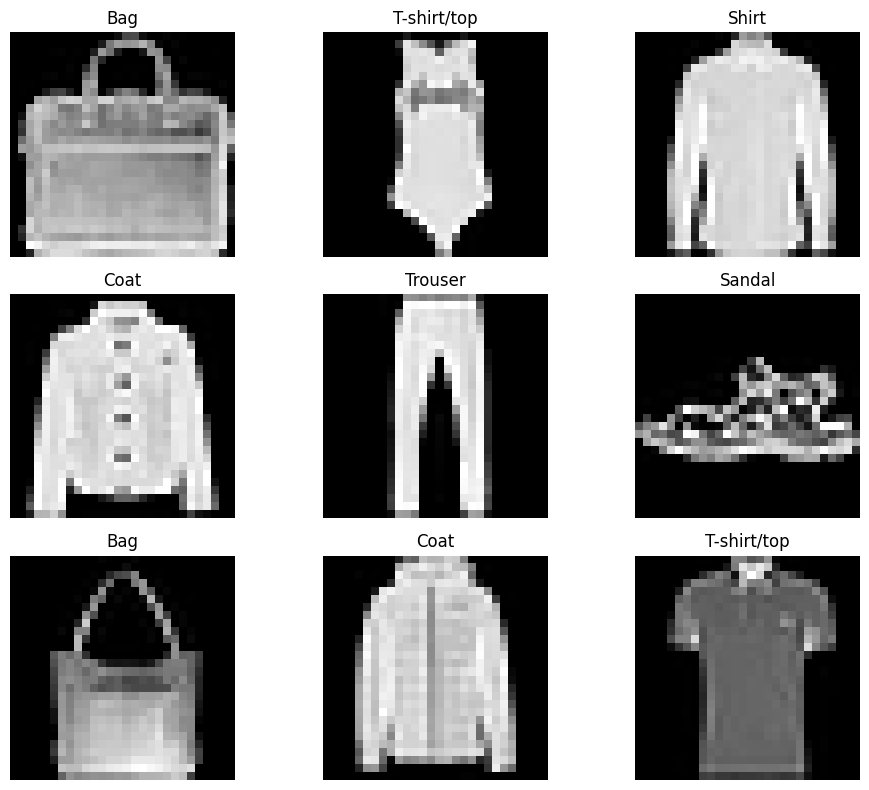

In [3]:
def show_images(dataloader):
    examples = iter(dataloader)
    example_data, example_targets = next(examples)
    
    fig = plt.figure(figsize=(10, 8))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(example_data[i][0], cmap='gray')
        plt.title(class_names[example_targets[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images(train_loader)

In [4]:
class FashionCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(FashionCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten_size = 64 * 7 * 7
        
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for Fashion-MNIST
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        
        x = self.pool2(F.relu(self.conv2(x)))
        
        x = x.view(-1, self.flatten_size)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.fc2(x)
        
        return x

In [5]:
model = FashionCNN(dropout_rate=0.5)
model.to(device)
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

FashionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Total number of parameters: 421,642


In [6]:
class MyAdamOptimizer(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
            
        defaults = dict(lr=lr, betas=betas, eps=eps)
        super(MyAdamOptimizer, self).__init__(params, defaults)
    
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
            
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                    
                grad = p.grad.data
                
                # Initialize state if it doesn't exist
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                
                state['step'] += 1
                #https://medium.com/@weidagang/demystifying-the-adam-optimizer-in-machine-learning-4401d162cb9e
                # Decay the first and second moment running average coefficients
                # m_t = β1 * m_{t-1} + (1 - β1) * g_t
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                
                # v_t = β2 * v_{t-1} + (1 - β2) * g_t^2
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                
                # Bias correction
                # Corrected m_t = m_t / (1 - β1^t)
                bias_correction1 = 1 - beta1 ** state['step']
                # Corrected v_t = v_t / (1 - β2^t)
                bias_correction2 = 1 - beta2 ** state['step']
                
                # Compute bias-corrected first and second moment estimates
                exp_avg_corrected = exp_avg / bias_correction1
                exp_avg_sq_corrected = exp_avg_sq / bias_correction2
                
                # Update parameters
                # θ_t = θ_{t-1} - α * m_t / (√v_t + ε)
                step_size = group['lr']
                p.data.addcdiv_(exp_avg_corrected, exp_avg_sq_corrected.sqrt().add_(group['eps']), value=-step_size)
                
        return loss


In [7]:
def train_and_evaluate(model, optimizer, criterion, train_loader, val_loader, test_loader, 
                       num_epochs=15, scheduler=None, optimizer_name="Unknown"):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'epoch_times': [],
        'optimizer': optimizer_name,
    }
    
    best_val_acc = 0.0
    best_model_weights = copy.deepcopy(model.state_dict())
    
    convergence_threshold = 0.80 
    converged_epoch = None
    
    print(f"Training with {optimizer_name}...")
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total
        
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        epoch_val_acc = val_correct / val_total
        
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_val_loss)
            else:
                scheduler.step()
        
        epoch_time = time.time() - start_time
        
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)
        history['epoch_times'].append(epoch_time)
        

        if converged_epoch is None and epoch_val_acc >= convergence_threshold:
            converged_epoch = epoch + 1
        
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_weights = copy.deepcopy(model.state_dict())
        
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}, "
              f"Time: {epoch_time:.2f}s")
    

    model.load_state_dict(best_model_weights)
    
    # Test phase
    model.eval()
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_accuracy = test_correct / test_total
    history['test_accuracy'] = test_accuracy
    history['best_val_accuracy'] = best_val_acc
    history['converged_epoch'] = converged_epoch
    
    print(f"\nFinal Results for {optimizer_name}:")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    if converged_epoch:
        print(f"Converged at epoch: {converged_epoch}")
    else:
        print("Did not reach convergence threshold")
    
    return history

In [8]:
# Modified function to train selected optimizers only
def train_selected_optimizers(num_epochs=15):
    all_results = {}
    
    criterion = nn.CrossEntropyLoss()
    
    optimizers_config = [
        # SGD with learning rate 0.01
        {"name": "SGD_lr0.01", "optimizer": lambda params: optim.SGD(params, lr=0.01)},
        # SGD with learning rate 0.001
        {"name": "SGD_lr0.001", "optimizer": lambda params: optim.SGD(params, lr=0.001)},
        
        # Custom Adam with learning rate 0.01
        {"name": "CustomAdam_lr0.01", "optimizer": lambda params: MyAdamOptimizer(params, lr=0.01)},
        # Custom Adam with learning rate 0.001
        {"name": "CustomAdam_lr0.001", "optimizer": lambda params: MyAdamOptimizer(params, lr=0.001)},
        
        # Nadam with learning rate 0.01
        {"name": "Nadam_lr0.01", "optimizer": lambda params: optim.NAdam(params, lr=0.01)},
        # Nadam with learning rate 0.001
        {"name": "Nadam_lr0.001", "optimizer": lambda params: optim.NAdam(params, lr=0.001)},
    ]
    
    for config in optimizers_config:
        model = FashionCNN(dropout_rate=0.5)
        model.to(device)
        
        # Create optimizer
        optimizer = config["optimizer"](model.parameters())
        
        # Train and evaluate
        print(f"\n{'='*50}")
        print(f"Training with {config['name']}")
        print(f"{'='*50}")
        
        results = train_and_evaluate(
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            num_epochs=num_epochs,
            optimizer_name=config['name']
        )
        
        all_results[config['name']] = results
        
        torch.save(model.state_dict(), f"models/{config['name']}.pth")
            
    return all_results

In [9]:
all_results = train_selected_optimizers()


Training with SGD_lr0.01
Training with SGD_lr0.01...


Epoch 1/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1/15 - Train Loss: 1.5017, Train Acc: 0.5119, Val Loss: 0.7467, Val Acc: 0.7500, Time: 7.69s


Epoch 2/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2/15 - Train Loss: 0.7385, Train Acc: 0.7342, Val Loss: 0.5822, Val Acc: 0.7834, Time: 7.34s


Epoch 3/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 3/15 - Train Loss: 0.6356, Train Acc: 0.7682, Val Loss: 0.5333, Val Acc: 0.8035, Time: 7.49s


Epoch 4/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 4/15 - Train Loss: 0.5863, Train Acc: 0.7859, Val Loss: 0.4979, Val Acc: 0.8145, Time: 7.44s


Epoch 5/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 5/15 - Train Loss: 0.5496, Train Acc: 0.7977, Val Loss: 0.4779, Val Acc: 0.8188, Time: 7.44s


Epoch 6/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 6/15 - Train Loss: 0.5238, Train Acc: 0.8098, Val Loss: 0.4654, Val Acc: 0.8256, Time: 7.32s


Epoch 7/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 7/15 - Train Loss: 0.5015, Train Acc: 0.8164, Val Loss: 0.4348, Val Acc: 0.8418, Time: 7.46s


Epoch 8/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 8/15 - Train Loss: 0.4795, Train Acc: 0.8248, Val Loss: 0.4184, Val Acc: 0.8492, Time: 7.58s


Epoch 9/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 9/15 - Train Loss: 0.4697, Train Acc: 0.8314, Val Loss: 0.4156, Val Acc: 0.8499, Time: 7.62s


Epoch 10/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 10/15 - Train Loss: 0.4557, Train Acc: 0.8363, Val Loss: 0.3922, Val Acc: 0.8584, Time: 7.43s


Epoch 11/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 11/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 11/15 - Train Loss: 0.4401, Train Acc: 0.8417, Val Loss: 0.3816, Val Acc: 0.8642, Time: 7.20s


Epoch 12/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 12/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 12/15 - Train Loss: 0.4335, Train Acc: 0.8435, Val Loss: 0.3737, Val Acc: 0.8664, Time: 7.62s


Epoch 13/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 13/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 13/15 - Train Loss: 0.4228, Train Acc: 0.8482, Val Loss: 0.3632, Val Acc: 0.8717, Time: 7.38s


Epoch 14/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 14/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 14/15 - Train Loss: 0.4141, Train Acc: 0.8511, Val Loss: 0.3733, Val Acc: 0.8658, Time: 7.34s


Epoch 15/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 15/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 15/15 - Train Loss: 0.4037, Train Acc: 0.8544, Val Loss: 0.3530, Val Acc: 0.8712, Time: 7.46s


Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Final Results for SGD_lr0.01:
Best Validation Accuracy: 0.8717
Test Accuracy: 0.8604
Converged at epoch: 3

Training with SGD_lr0.001
Training with SGD_lr0.001...


Epoch 1/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1/15 - Train Loss: 2.2533, Train Acc: 0.2300, Val Loss: 2.2040, Val Acc: 0.3280, Time: 7.45s


Epoch 2/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2/15 - Train Loss: 2.1351, Train Acc: 0.3581, Val Loss: 2.0339, Val Acc: 0.4263, Time: 7.56s


Epoch 3/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 3/15 - Train Loss: 1.8944, Train Acc: 0.4368, Val Loss: 1.6887, Val Acc: 0.5926, Time: 7.52s


Epoch 4/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 4/15 - Train Loss: 1.5558, Train Acc: 0.5059, Val Loss: 1.3167, Val Acc: 0.6640, Time: 7.53s


Epoch 5/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 5/15 - Train Loss: 1.2850, Train Acc: 0.5704, Val Loss: 1.0763, Val Acc: 0.6893, Time: 7.48s


Epoch 6/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 6/15 - Train Loss: 1.1157, Train Acc: 0.6177, Val Loss: 0.9295, Val Acc: 0.7213, Time: 7.65s


Epoch 7/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 7/15 - Train Loss: 1.0007, Train Acc: 0.6525, Val Loss: 0.8368, Val Acc: 0.7349, Time: 7.44s


Epoch 8/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 8/15 - Train Loss: 0.9185, Train Acc: 0.6793, Val Loss: 0.7738, Val Acc: 0.7449, Time: 7.44s


Epoch 9/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 9/15 - Train Loss: 0.8601, Train Acc: 0.6965, Val Loss: 0.7321, Val Acc: 0.7520, Time: 7.60s


Epoch 10/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 10/15 - Train Loss: 0.8201, Train Acc: 0.7091, Val Loss: 0.7025, Val Acc: 0.7567, Time: 7.52s


Epoch 11/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 11/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 11/15 - Train Loss: 0.7867, Train Acc: 0.7215, Val Loss: 0.6784, Val Acc: 0.7585, Time: 7.35s


Epoch 12/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 12/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 12/15 - Train Loss: 0.7613, Train Acc: 0.7279, Val Loss: 0.6579, Val Acc: 0.7666, Time: 7.45s


Epoch 13/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 13/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 13/15 - Train Loss: 0.7414, Train Acc: 0.7351, Val Loss: 0.6418, Val Acc: 0.7708, Time: 7.35s


Epoch 14/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 14/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 14/15 - Train Loss: 0.7270, Train Acc: 0.7403, Val Loss: 0.6299, Val Acc: 0.7758, Time: 7.32s


Epoch 15/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 15/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 15/15 - Train Loss: 0.7083, Train Acc: 0.7462, Val Loss: 0.6178, Val Acc: 0.7781, Time: 7.61s


Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Final Results for SGD_lr0.001:
Best Validation Accuracy: 0.7781
Test Accuracy: 0.7690
Did not reach convergence threshold

Training with CustomAdam_lr0.01
Training with CustomAdam_lr0.01...


Epoch 1/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1/15 - Train Loss: 0.6070, Train Acc: 0.7833, Val Loss: 0.3736, Val Acc: 0.8632, Time: 7.51s


Epoch 2/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2/15 - Train Loss: 0.4211, Train Acc: 0.8500, Val Loss: 0.3389, Val Acc: 0.8784, Time: 7.33s


Epoch 3/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 3/15 - Train Loss: 0.3885, Train Acc: 0.8599, Val Loss: 0.3599, Val Acc: 0.8704, Time: 7.62s


Epoch 4/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 4/15 - Train Loss: 0.3744, Train Acc: 0.8647, Val Loss: 0.3382, Val Acc: 0.8745, Time: 7.55s


Epoch 5/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 5/15 - Train Loss: 0.3578, Train Acc: 0.8700, Val Loss: 0.3279, Val Acc: 0.8747, Time: 7.66s


Epoch 6/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 6/15 - Train Loss: 0.3443, Train Acc: 0.8764, Val Loss: 0.3125, Val Acc: 0.8843, Time: 7.55s


Epoch 7/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 7/15 - Train Loss: 0.3377, Train Acc: 0.8756, Val Loss: 0.3131, Val Acc: 0.8826, Time: 7.74s


Epoch 8/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 8/15 - Train Loss: 0.3345, Train Acc: 0.8775, Val Loss: 0.3052, Val Acc: 0.8911, Time: 7.56s


Epoch 9/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 9/15 - Train Loss: 0.3353, Train Acc: 0.8788, Val Loss: 0.3053, Val Acc: 0.8898, Time: 7.48s


Epoch 10/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 10/15 - Train Loss: 0.3298, Train Acc: 0.8803, Val Loss: 0.3198, Val Acc: 0.8855, Time: 7.52s


Epoch 11/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 11/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 11/15 - Train Loss: 0.3258, Train Acc: 0.8822, Val Loss: 0.3115, Val Acc: 0.8891, Time: 7.54s


Epoch 12/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 12/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 12/15 - Train Loss: 0.3217, Train Acc: 0.8826, Val Loss: 0.3142, Val Acc: 0.8877, Time: 7.41s


Epoch 13/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 13/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 13/15 - Train Loss: 0.3178, Train Acc: 0.8833, Val Loss: 0.2901, Val Acc: 0.8986, Time: 7.47s


Epoch 14/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 14/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 14/15 - Train Loss: 0.3172, Train Acc: 0.8834, Val Loss: 0.3052, Val Acc: 0.8882, Time: 7.50s


Epoch 15/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 15/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 15/15 - Train Loss: 0.3132, Train Acc: 0.8858, Val Loss: 0.3351, Val Acc: 0.8842, Time: 7.38s


Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Final Results for CustomAdam_lr0.01:
Best Validation Accuracy: 0.8986
Test Accuracy: 0.8905
Converged at epoch: 1

Training with CustomAdam_lr0.001
Training with CustomAdam_lr0.001...


Epoch 1/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1/15 - Train Loss: 0.6388, Train Acc: 0.7699, Val Loss: 0.4001, Val Acc: 0.8520, Time: 7.49s


Epoch 2/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2/15 - Train Loss: 0.4134, Train Acc: 0.8510, Val Loss: 0.3249, Val Acc: 0.8819, Time: 7.61s


Epoch 3/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 3/15 - Train Loss: 0.3570, Train Acc: 0.8718, Val Loss: 0.2922, Val Acc: 0.8926, Time: 7.63s


Epoch 4/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 4/15 - Train Loss: 0.3184, Train Acc: 0.8869, Val Loss: 0.2714, Val Acc: 0.9020, Time: 7.47s


Epoch 5/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 5/15 - Train Loss: 0.2911, Train Acc: 0.8943, Val Loss: 0.2703, Val Acc: 0.9038, Time: 7.75s


Epoch 6/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 6/15 - Train Loss: 0.2706, Train Acc: 0.9004, Val Loss: 0.2577, Val Acc: 0.9070, Time: 7.42s


Epoch 7/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 7/15 - Train Loss: 0.2556, Train Acc: 0.9076, Val Loss: 0.2468, Val Acc: 0.9086, Time: 7.69s


Epoch 8/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 8/15 - Train Loss: 0.2358, Train Acc: 0.9139, Val Loss: 0.2427, Val Acc: 0.9111, Time: 7.55s


Epoch 9/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 9/15 - Train Loss: 0.2225, Train Acc: 0.9187, Val Loss: 0.2389, Val Acc: 0.9163, Time: 7.55s


Epoch 10/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 10/15 - Train Loss: 0.2098, Train Acc: 0.9225, Val Loss: 0.2334, Val Acc: 0.9166, Time: 7.65s


Epoch 11/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 11/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 11/15 - Train Loss: 0.1981, Train Acc: 0.9263, Val Loss: 0.2353, Val Acc: 0.9167, Time: 7.54s


Epoch 12/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 12/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 12/15 - Train Loss: 0.1885, Train Acc: 0.9306, Val Loss: 0.2274, Val Acc: 0.9203, Time: 7.72s


Epoch 13/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 13/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 13/15 - Train Loss: 0.1763, Train Acc: 0.9337, Val Loss: 0.2286, Val Acc: 0.9225, Time: 7.52s


Epoch 14/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 14/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 14/15 - Train Loss: 0.1693, Train Acc: 0.9369, Val Loss: 0.2349, Val Acc: 0.9229, Time: 7.62s


Epoch 15/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 15/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 15/15 - Train Loss: 0.1584, Train Acc: 0.9403, Val Loss: 0.2582, Val Acc: 0.9184, Time: 7.60s


Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Final Results for CustomAdam_lr0.001:
Best Validation Accuracy: 0.9229
Test Accuracy: 0.9181
Converged at epoch: 1

Training with Nadam_lr0.01
Training with Nadam_lr0.01...


Epoch 1/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1/15 - Train Loss: 0.6348, Train Acc: 0.7771, Val Loss: 0.3721, Val Acc: 0.8638, Time: 7.29s


Epoch 2/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2/15 - Train Loss: 0.3990, Train Acc: 0.8553, Val Loss: 0.3145, Val Acc: 0.8868, Time: 7.37s


Epoch 3/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 3/15 - Train Loss: 0.3633, Train Acc: 0.8689, Val Loss: 0.3139, Val Acc: 0.8836, Time: 7.41s


Epoch 4/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 4/15 - Train Loss: 0.3434, Train Acc: 0.8757, Val Loss: 0.2961, Val Acc: 0.8929, Time: 7.59s


Epoch 5/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 5/15 - Train Loss: 0.3336, Train Acc: 0.8776, Val Loss: 0.3056, Val Acc: 0.8885, Time: 7.51s


Epoch 6/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 6/15 - Train Loss: 0.3229, Train Acc: 0.8821, Val Loss: 0.3046, Val Acc: 0.8900, Time: 7.35s


Epoch 7/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 7/15 - Train Loss: 0.3225, Train Acc: 0.8807, Val Loss: 0.3077, Val Acc: 0.8942, Time: 7.37s


Epoch 8/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 8/15 - Train Loss: 0.3190, Train Acc: 0.8841, Val Loss: 0.2868, Val Acc: 0.8959, Time: 7.47s


Epoch 9/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 9/15 - Train Loss: 0.3136, Train Acc: 0.8874, Val Loss: 0.3051, Val Acc: 0.8883, Time: 7.53s


Epoch 10/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 10/15 - Train Loss: 0.3086, Train Acc: 0.8870, Val Loss: 0.2794, Val Acc: 0.9038, Time: 7.74s


Epoch 11/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 11/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 11/15 - Train Loss: 0.3075, Train Acc: 0.8865, Val Loss: 0.2861, Val Acc: 0.8994, Time: 7.58s


Epoch 12/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 12/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 12/15 - Train Loss: 0.3486, Train Acc: 0.8761, Val Loss: 0.2990, Val Acc: 0.8950, Time: 7.54s


Epoch 13/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 13/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 13/15 - Train Loss: 0.3067, Train Acc: 0.8885, Val Loss: 0.3088, Val Acc: 0.8987, Time: 7.46s


Epoch 14/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 14/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 14/15 - Train Loss: 0.2958, Train Acc: 0.8911, Val Loss: 0.3115, Val Acc: 0.8911, Time: 7.41s


Epoch 15/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 15/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 15/15 - Train Loss: 0.2958, Train Acc: 0.8916, Val Loss: 0.2892, Val Acc: 0.9017, Time: 7.25s


Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Final Results for Nadam_lr0.01:
Best Validation Accuracy: 0.9038
Test Accuracy: 0.8948
Converged at epoch: 1

Training with Nadam_lr0.001
Training with Nadam_lr0.001...


Epoch 1/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1/15 - Train Loss: 0.6448, Train Acc: 0.7692, Val Loss: 0.3804, Val Acc: 0.8682, Time: 7.58s


Epoch 2/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2/15 - Train Loss: 0.4074, Train Acc: 0.8545, Val Loss: 0.3199, Val Acc: 0.8818, Time: 7.50s


Epoch 3/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 3/15 - Train Loss: 0.3554, Train Acc: 0.8737, Val Loss: 0.2891, Val Acc: 0.8934, Time: 7.52s


Epoch 4/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 4/15 - Train Loss: 0.3183, Train Acc: 0.8859, Val Loss: 0.2706, Val Acc: 0.9040, Time: 7.60s


Epoch 5/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 5/15 - Train Loss: 0.2929, Train Acc: 0.8959, Val Loss: 0.2611, Val Acc: 0.9047, Time: 7.37s


Epoch 6/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 6/15 - Train Loss: 0.2715, Train Acc: 0.9019, Val Loss: 0.2648, Val Acc: 0.9042, Time: 7.51s


Epoch 7/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 7/15 - Train Loss: 0.2556, Train Acc: 0.9077, Val Loss: 0.2429, Val Acc: 0.9106, Time: 7.61s


Epoch 8/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 8/15 - Train Loss: 0.2404, Train Acc: 0.9112, Val Loss: 0.2370, Val Acc: 0.9147, Time: 7.40s


Epoch 9/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 9/15 - Train Loss: 0.2232, Train Acc: 0.9194, Val Loss: 0.2304, Val Acc: 0.9187, Time: 7.44s


Epoch 10/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 10/15 - Train Loss: 0.2130, Train Acc: 0.9217, Val Loss: 0.2308, Val Acc: 0.9198, Time: 7.38s


Epoch 11/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 11/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 11/15 - Train Loss: 0.2018, Train Acc: 0.9261, Val Loss: 0.2281, Val Acc: 0.9210, Time: 7.41s


Epoch 12/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 12/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 12/15 - Train Loss: 0.1895, Train Acc: 0.9293, Val Loss: 0.2323, Val Acc: 0.9174, Time: 7.71s


Epoch 13/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 13/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 13/15 - Train Loss: 0.1791, Train Acc: 0.9334, Val Loss: 0.2263, Val Acc: 0.9242, Time: 7.42s


Epoch 14/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 14/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 14/15 - Train Loss: 0.1710, Train Acc: 0.9355, Val Loss: 0.2309, Val Acc: 0.9241, Time: 7.41s


Epoch 15/15 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 15/15 [Val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 15/15 - Train Loss: 0.1612, Train Acc: 0.9388, Val Loss: 0.2306, Val Acc: 0.9243, Time: 7.52s


Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Final Results for Nadam_lr0.001:
Best Validation Accuracy: 0.9243
Test Accuracy: 0.9193
Converged at epoch: 1


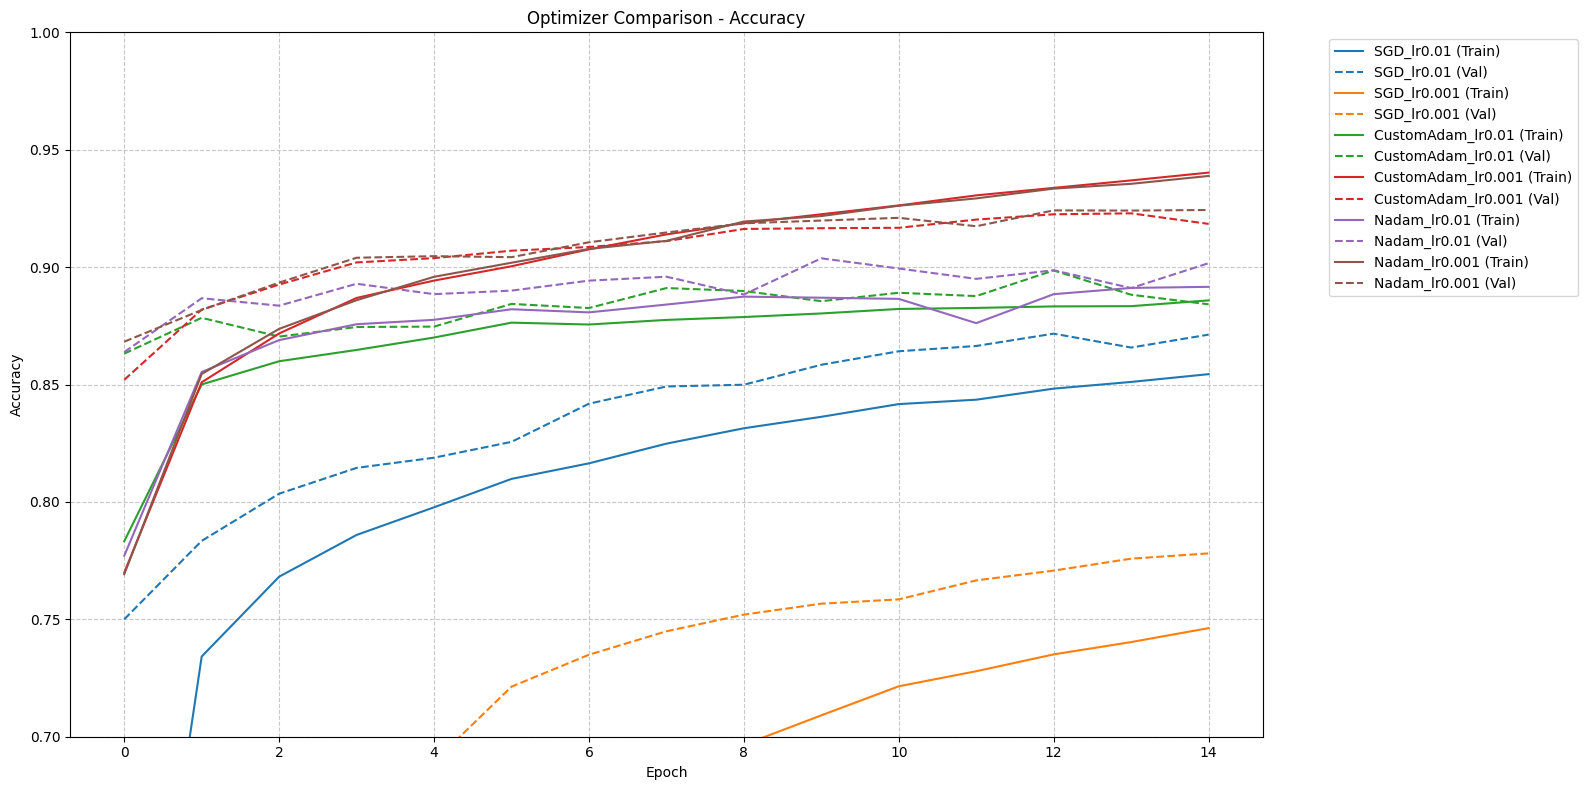

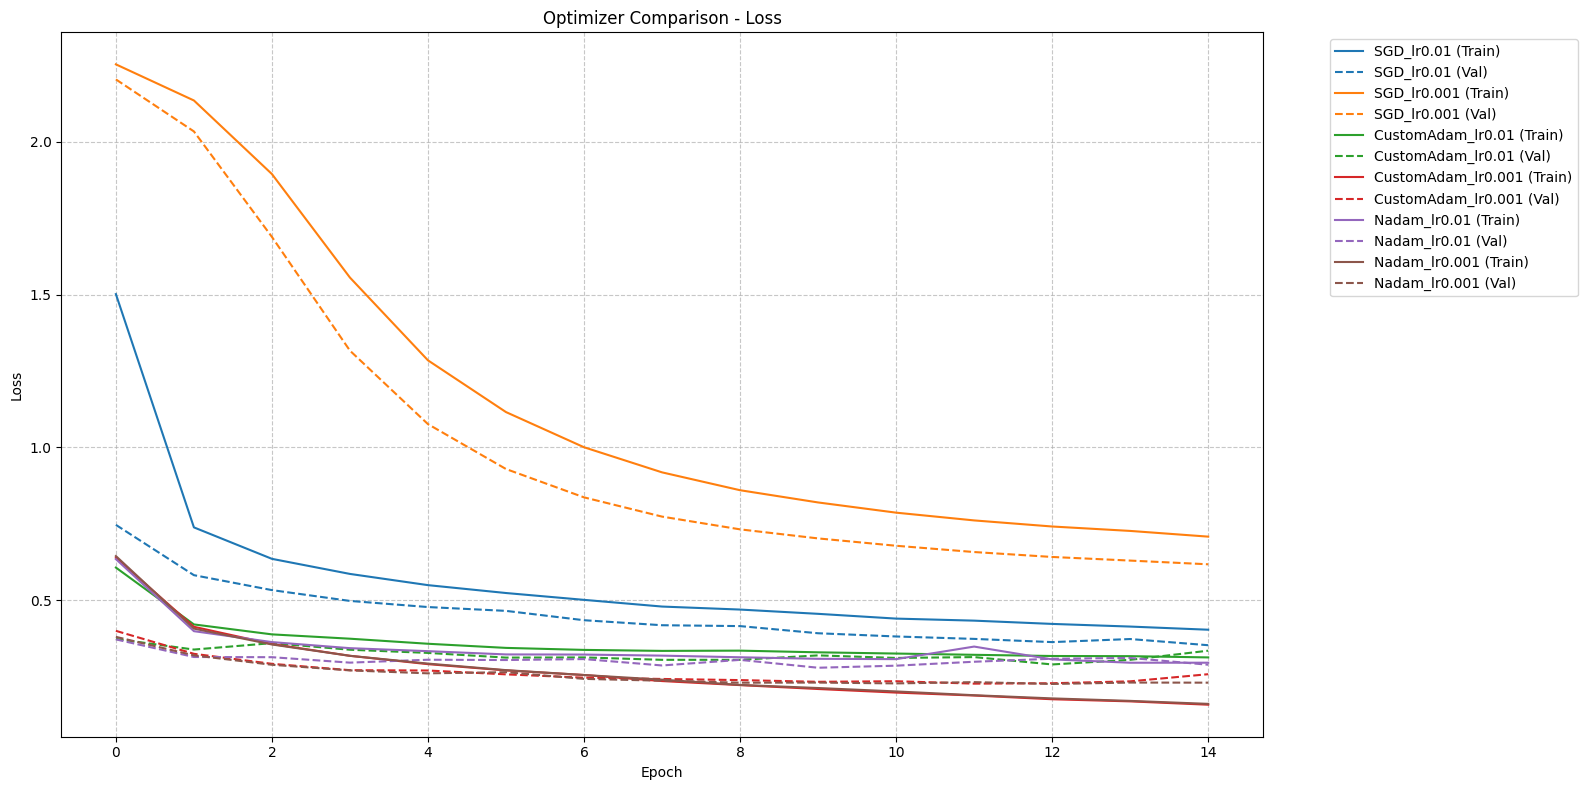

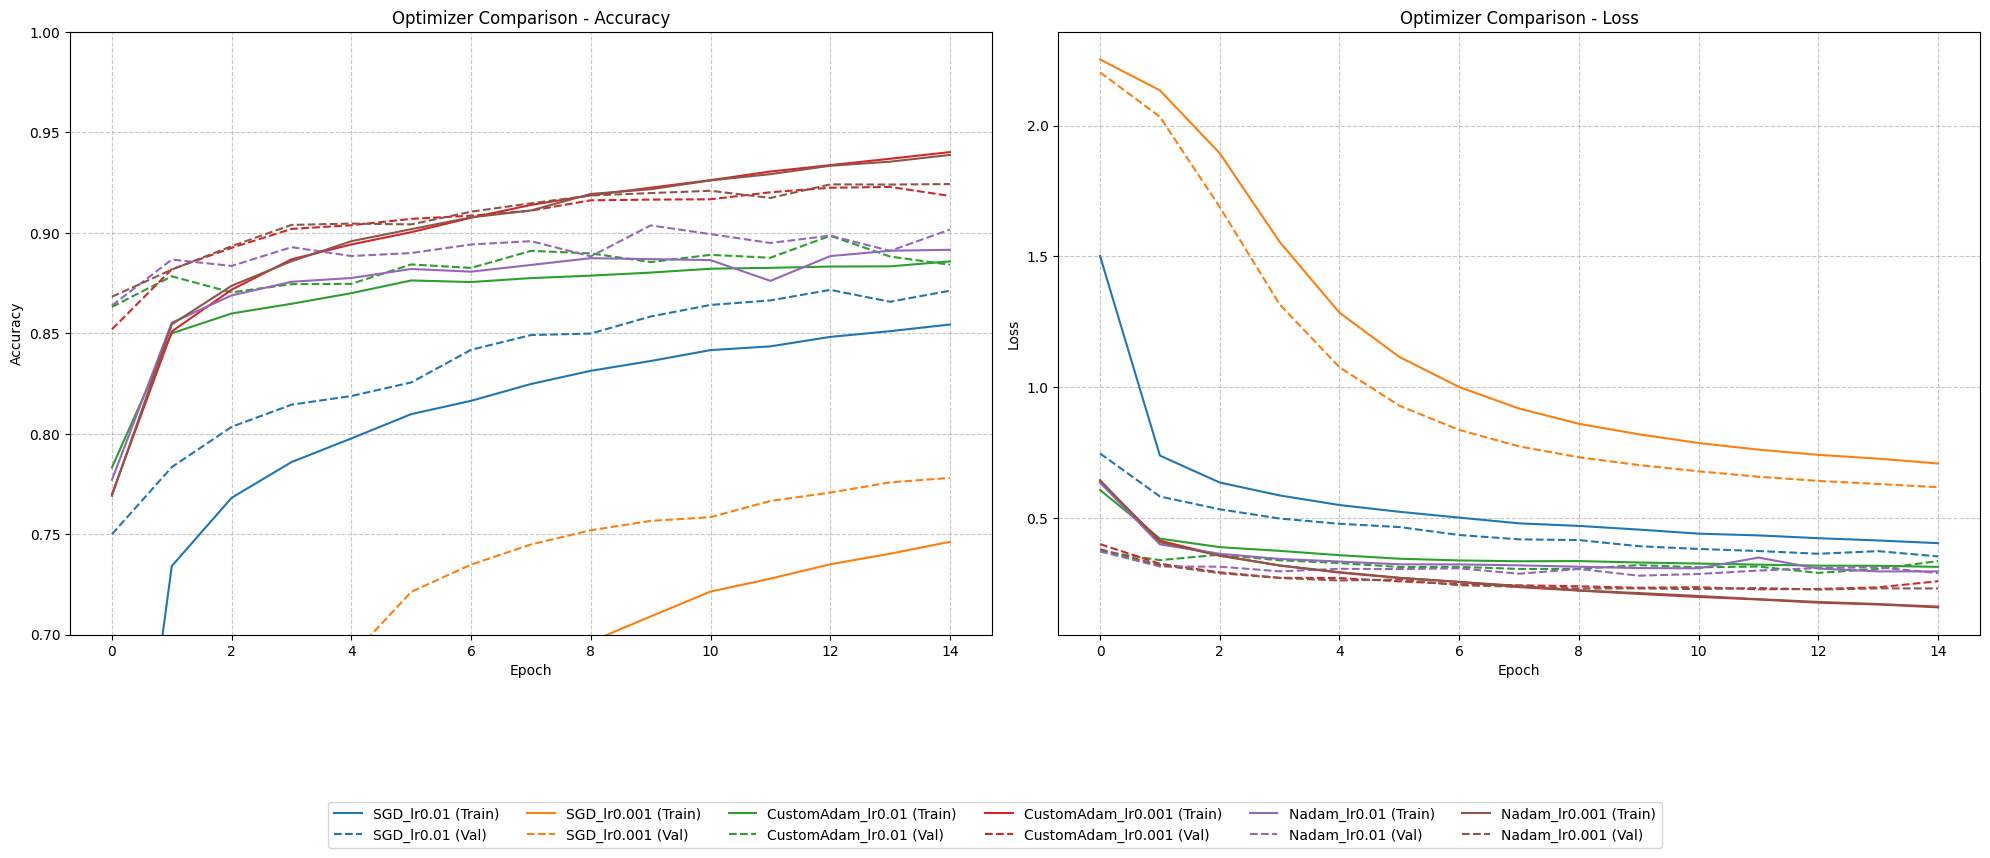

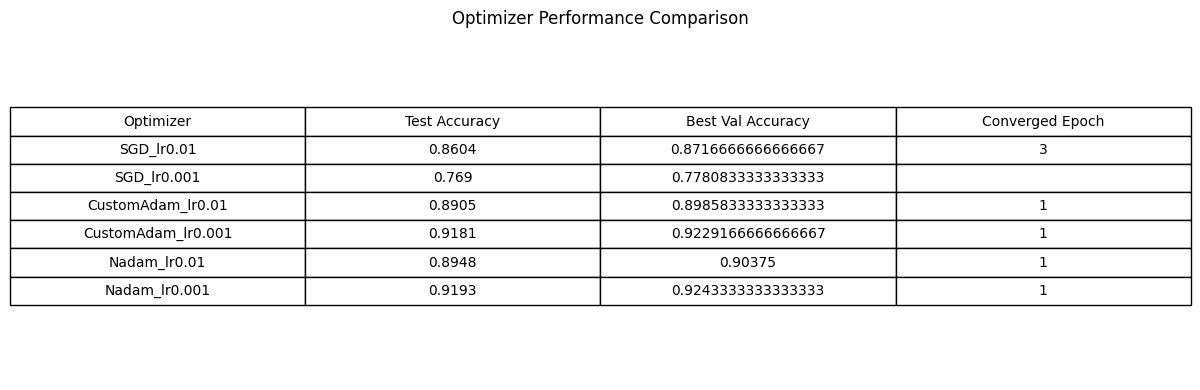

In [10]:
def plot_optimizer_results(all_results, metric='accuracy'):
    plt.figure(figsize=(16, 8))
    
    colors = {
        "SGD_lr0.01": "#1f77b4",
        "SGD_lr0.001": "#ff7f0e",
        "CustomAdam_lr0.01": "#2ca02c", 
        "CustomAdam_lr0.001": "#d62728",
        "Nadam_lr0.01": "#9467bd",
        "Nadam_lr0.001": "#8c564b"
    }
    
    for optimizer_name, results in all_results.items():
        if metric == 'accuracy':
            plt.plot(results['train_acc'], 
                     linestyle='-', 
                     color=colors[optimizer_name],
                     label=f"{optimizer_name} (Train)")
            plt.plot(results['val_acc'], 
                     linestyle='--', 
                     color=colors[optimizer_name],
                     label=f"{optimizer_name} (Val)")
            plt.ylabel('Accuracy')
            plt.title('Optimizer Comparison - Accuracy')
            if min(np.min(results['train_acc']), np.min(results['val_acc'])) > 0.7:
                plt.ylim(0.7, 1.0)
        else:
            plt.plot(results['train_loss'], 
                     linestyle='-', 
                     color=colors[optimizer_name],
                     label=f"{optimizer_name} (Train)")
            plt.plot(results['val_loss'], 
                     linestyle='--', 
                     color=colors[optimizer_name],
                     label=f"{optimizer_name} (Val)")
            plt.ylabel('Loss')
            plt.title('Optimizer Comparison - Loss')
    
    plt.xlabel('Epoch')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


plot_optimizer_results(all_results, metric='accuracy')
plot_optimizer_results(all_results, metric='loss')


def plot_optimizer_comparison(all_results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    colors = {
        "SGD_lr0.01": "#1f77b4",
        "SGD_lr0.001": "#ff7f0e",
        "CustomAdam_lr0.01": "#2ca02c", 
        "CustomAdam_lr0.001": "#d62728",
        "Nadam_lr0.01": "#9467bd",
        "Nadam_lr0.001": "#8c564b"
    }
    
    # Plot accuracy
    for optimizer_name, results in all_results.items():
        ax1.plot(results['train_acc'], 
                 linestyle='-', 
                 color=colors[optimizer_name],
                 label=f"{optimizer_name} (Train)")
        ax1.plot(results['val_acc'], 
                 linestyle='--', 
                 color=colors[optimizer_name],
                 label=f"{optimizer_name} (Val)")
    
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Optimizer Comparison - Accuracy')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.set_ylim(0.7, 1.0)  # Focus on relevant accuracy range
    
    # Plot loss
    for optimizer_name, results in all_results.items():
        ax2.plot(results['train_loss'], 
                 linestyle='-', 
                 color=colors[optimizer_name],
                 label=f"{optimizer_name} (Train)")
        ax2.plot(results['val_loss'], 
                 linestyle='--', 
                 color=colors[optimizer_name],
                 label=f"{optimizer_name} (Val)")
    
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Optimizer Comparison - Loss')
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Put legend outside of both plots
    handles, labels = ax2.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), 
               ncol=6, frameon=True)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Make room for the legend
    plt.show()

plot_optimizer_comparison(all_results)

def plot_performance_table(all_results):
    data = []
    for optimizer_name, results in all_results.items():
        data.append([
            optimizer_name,
            results['test_accuracy'],
            results['best_val_accuracy'],
            results['converged_epoch'] if 'converged_epoch' in results else 'N/A'
        ])
    
    fig, ax = plt.figure(figsize=(12, 4)), plt.gca()
    ax.axis('off')
    ax.axis('tight')
    
    table = ax.table(
        cellText=data,
        colLabels=['Optimizer', 'Test Accuracy', 'Best Val Accuracy', 'Converged Epoch'],
        loc='center',
        cellLoc='center'
    )
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    
    plt.title('Optimizer Performance Comparison')
    plt.tight_layout()
    plt.show()

plot_performance_table(all_results)